In [1]:
%matplotlib inline
import numpy as np
np.random.seed(555)
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# 推移行列などの初期化
# 観測値は一次元とする
def FGHset(n_dim_trend, n_dim_obs=1, n_dim_series=0, Q_sigma2=10):
    n_dim_Q = (n_dim_trend!=0) + (n_dim_series!=0)
    if n_dim_series>0:
        n_dim_state = n_dim_trend + n_dim_series -1
    else:
        n_dim_state = n_dim_trend
       
    # 行列の初期化
    G = np.zeros((n_dim_state, n_dim_Q))
    F = np.zeros((n_dim_state, n_dim_state))
    H = np.zeros((n_dim_obs, n_dim_state))
    Q = np.eye(n_dim_Q) * Q_sigma2
    
    ## トレンドモデルのブロック行列の構築
    G[0,0] = 1
    H[0,0] = 1
    if n_dim_trend==1: 
        F[0,0] = 1
    elif n_dim_trend==2:
        F[0,0] = 2
        F[0,1] = -1
        F[1,0] = 1
    elif n_dim_trend==3:
        F[0,0] = 3
        F[0,1] = -3
        F[0,2] = 1
        F[1,0] = 1
        F[2,1] = 1
        
    start_elem = n_dim_trend
    start_col = n_dim_trend
    # 季節調整成分のブロック行列の構築
    if n_dim_series>0:
        G[start_elem, 1] = 1
        H[0, start_elem] = 1
        for i in range(n_dim_series-1): 
            F[start_elem, start_elem+i] = -1
        for i in range(n_dim_series-2): 
            F[start_elem+i+1, start_elem+i] = 1
    
    # PyKalmanのQはG.dot(Q).dot(G.T)を想定しているためQをupdate
    Q = G.dot(Q).dot(G.T)
    
    return n_dim_state, F, H, Q

## 固定ラグ平滑化あり（外部拡張する場合）

In [3]:
from scipy.stats import multivariate_normal, cauchy
from numpy.random import uniform


class GaussianNoise(object):
    """多次元ガウス分布
    """
    def __init__(self, covariance):
        self.covariance = covariance
        self.n_state = len(covariance)

    def generate(self, n_particles):
        """ノイズの生成
        """
        return (multivariate_normal.rvs(
            np.zeros(self.n_state), self.covariance, n_particles).T)
        
    def pdf(self, y, predicted_obs):
        """確率密度
        """
        r_y = y.reshape(y.size)
        likelihoods = np.empty(predicted_obs.shape[1])
        for i, pred_y in enumerate(predicted_obs.T):
            likelihoods[i] = multivariate_normal.pdf(r_y, 
                                                     pred_y, 
                                                     cov=self.covariance)
        return likelihoods

    def update_parameters(self, particles, target_idxs):
        for i in range(len(self.covariance)):
            self.covariance[i, i] = particles[target_idxs[i]].mean()


class FixedLagParticleFilter(object):
    def __init__(self, 
                 n_dim_state=None, n_dim_obs=None,
                 transition_func=None, observation_func=None,
                 system_noise=None, observation_noise=None,
                 n_particles=None):
        # 観測データの次元数
        self.n_dim_obs = n_dim_obs
        # 粒子の数
        self.n_particles = n_particles
        # リサンプリングに使用する横櫛（使い回す）
        self.TEETH = np.arange(0, 1, float(1.0)/n_particles)
        # 粒子の単位質量（観測データへの適合度）
        self.weights = np.zeros(n_particles)
        # 粒子
        self.particles = np.zeros((n_dim_state, n_particles))
        # 予測分布（粒子）
        self.predicted_particles = np.zeros((n_dim_state, n_particles))

        self.transition_func = transition_func
        self.observation_func = observation_func
        self.system_noise = system_noise
        self.observation_noise = observation_noise
        
        self._init_praticles_distribution()

    def _init_praticles_distribution(self):
        """粒子の初期化
        x_{0|0}
        """
        self.particles = self.system_noise.generate(self.n_particles)

    def update(self, y):
        """リサンプリング
        """
        if isinstance(y, float):
            y = np.array([y])
        self._update_particles()
        self._update_particles_weight(y)
        self._resample()

    def forecast(self):
        """長期予測
        """
        self.particles = self.transition_func(self.particles)
        return self.observation_func(self.particles).mean(axis=1)

    def generate_system_noise(self):
        """v_t"""
        return self.system_noise.generate(self.n_particles)

    def _update_particles(self):
        """システムモデルの計算（新たな粒子を生成することで予測分布を計算）
        x_{t|t-1}
        """
        self.predicted_particles = \
            self.transition_func(self.particles) + self.generate_system_noise()

    def _update_particles_weight(self, y):
        """各粒子の重みの計算（予測値が観測値に対してどれだけ適合しているかを計算）
        w_t
        """
        self.weights = self.observation_noise.pdf(
                y, self.observation_func(self.predicted_particles))
        
    def _normalize_weights(self):
        """\tild{w}_t"""
        self.weights = self.weights / sum(self.weights)

    def _resample(self):
        """x_{t|t}"""
        self._normalize_weights()

        # accumulate weight
        cum = np.cumsum(self.weights)

        # create roulette pointer 
        base = uniform(0, float(1.0)/self.n_particles)
        pointers = self.TEETH + base

        # select particles
        self.selected_idx = [np.where(cum>=p)[0][0] for p in pointers]
        self.particles = self.predicted_particles[:, self.selected_idx]

    def predict(self):
        """フィルタ系列の予測
        """
        return (np.sum(
            self.observation_func(self.predicted_particles) * self.weights,
            axis=1))

    def fl_smoothing(self, past_particles, lag):
        """固定ラグ平滑化
        """
        # 平滑化分布
        smoothed = np.empty([lag, self.n_dim_obs, self.n_particles])
        for lg in range(lag):
            smoothed[lg] = self.observation_func(
                past_particles[lg, :, self.selected_idx].T)
        return smoothed

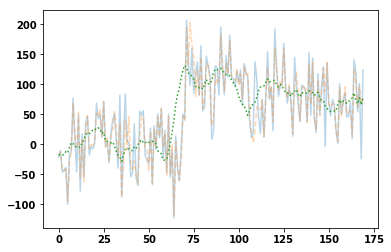

In [4]:
np.random.seed(555)

n_dim_trend = 2
n_dim_obs = 1
n_dim_series = 12
n_particles = 200
system_sigma2 = 200

n_dim_state, F, H, Q = FGHset(n_dim_trend, 
                              n_dim_obs, 
                              n_dim_series, 
                              Q_sigma2=system_sigma2)

observation_sigma2 = 300
params_sigma2 = 150
transition_func = lambda x: F.dot(x)
observation_func = lambda x: H.dot(x)
system_noise = GaussianNoise(Q)
observation_noise = GaussianNoise(np.eye(n_dim_obs)*observation_sigma2)

pf = FixedLagParticleFilter(n_dim_state=n_dim_state, 
                            n_dim_obs=n_dim_obs,
                            transition_func=transition_func,
                            observation_func=observation_func,
                            system_noise=system_noise,
                            observation_noise=observation_noise,
                            n_particles=n_particles)

y = np.concatenate([np.random.normal(0,50,size=70), 
                    np.random.normal(100,50,size=100)])
# 長期予測結果の保存ベクトル
predicted = np.empty(len(y))
# 平滑化系列の保存ベクトル
smoothed = np.empty(len(y))

n_lag = 10
past_particles = np.empty([n_lag, n_dim_state, n_particles])

for i, d in enumerate(y):
    pf.update(d)
    predicted[i] = pf.predict()
    # ラグ数分のデータがたまった後は平滑化分布をもとにt-Lの値を計算
    if i>n_lag-1:
        smoothed_values = pf.fl_smoothing(past_particles, n_lag)
        smoothed[i-n_lag] = smoothed_values.mean(axis=(0,2))
        # 最終時点に到達した場合
        if i==len(y)-1:
            smoothed[i] = predicted[i]
            for i_lag in range(1, n_lag):
                smoothed[i-i_lag] = \
                    smoothed_values[-i_lag:].mean(axis=(0,2))      
        past_particles[:-1] = past_particles[1:][:, :, pf.selected_idx]
        past_particles[-1] = pf.particles
        
    # ラグ数分のデータがたまるまでは過去分の粒子を保存するだけ
    else:
        past_particles = past_particles[:, :, pf.selected_idx]
        past_particles[i] = pf.particles
            
rng = range(len(predicted))
plt.plot(rng, y, label="observation", alpha=0.3)
plt.plot(rng, predicted, '--', label="predict", alpha=0.3)
plt.plot(rng, smoothed, ':', label="smoothed")